This notebook generates data used in plots in "Plot_first_gap.ipynb".

In [ ]:
%pip install pennylane
%pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 39.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np

Functions to prepare the state and evolve it in the imaginary time.

In [ ]:
#Trotter for Ising
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma_y = np.array([[0.0, -1j], [1j, 0.0]])
W = np.array([[1.0, -1j], [1.0, 1j]])/np.sqrt(2.)

def Ising_U(dt, J, h, hz):
  """
  Returns the unitary matrix for the Ising Trotterization.

  Args:
    dt (np.float): Trotter time step;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.

  Returns:
     U - unitary matrix used in Trotter evolution on two neighbour sites.
  """
  H = -J*np.einsum("ij, kl -> ikjl", sigma_z, sigma_z)
  H -= h*np.einsum("ij, kl -> ikjl", sigma_x, np.eye(2))/2
  H -= h*np.einsum("ij, kl -> ikjl", np.eye(2), sigma_x)/2
  H -= hz*np.einsum("ij, kl -> ikjl", sigma_z, np.eye(2))/2
  H -= hz*np.einsum("ij, kl -> ikjl", np.eye(2), sigma_z)/2
  H = np.reshape(H, [4,4])
  d, V = np.linalg.eigh(H)
  U = np.einsum("ij, j, kj -> ik", V, np.exp(-1j*dt*d), V)
  return U

def Trotter_Ising(dt, J, h, hz, wqubits):
  """
  Applies Trotterized evolution with Ising Hamiltonian in real time.
  Note, that wqubits should be even.

  Args:
    dt (np.float): Trotter time step;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    wqubits (np.int) : number of physical (without ancilla) qubits

  """
  N = wqubits//2
  U = Ising_U(dt, J, h, hz)
  for q in range(N):
    qml.QubitUnitary(U, wires = [2*q,2*q+1])
  for q in range(N-1):
    qml.QubitUnitary(U, wires = [2*q+1,2*q+2])
  qml.QubitUnitary(U, wires = [wqubits-1, 0])


@qml.defer_measurements
def imaginary_time_step_Ising(dt, J, h,hz, nqubits, theta0):
  """
  Applies one step of Trotterized evolution with Ising Hamiltonian in imaginery time.
  Note, that wqubits should be even.

    Args:
    dt (np.float): Trotter time step of real time evolution;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
    theta0 (np.float): the angle of the Rz gate, as defined in arXiv:2111.12471
  """
  wqubits = nqubits - 1
  qml.Hadamard(wires = [nqubits-1])
  qml.QubitUnitary(W, wires = [nqubits-1])
  qml.ctrl(Trotter_Ising, [nqubits-1], control_values = [0])(dt, J, h, hz, wqubits)
  qml.ctrl(qml.adjoint(Trotter_Ising), [nqubits-1], control_values = [1])(dt, J, h, hz, wqubits)
  qml.RZ(-2*theta0, wires = [nqubits-1])
  qml.adjoint(qml.QubitUnitary(W, wires = [nqubits-1]))
  qml.measure(wires = [nqubits-1], postselect = 0)

def imaginary_time_evolution_Ising(steps, m0, J, h,hz, nqubits):
  """
  Applies Trotterized evolution with Ising Hamiltonian in imaginery time.
  steps controls the Trotter time steps.
  Note, that nqubits should be odd.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
  """
  s = m0/np.sqrt(1-m0**2)
  dtau = steps*s
  kappa = np.sign(m0 - 1./np.sqrt(2))
  theta0 = kappa*np.arccos((m0 + np.sqrt(1-m0**2))/np.sqrt(2))

  for c in range(len(steps)):
    dt = dtau[c]
    imaginary_time_step_Ising(dt, J, h, hz, nqubits, theta0)

def state_prep(nqubits):
  """
  Prepares the initial product state.
  You can freely change this state, it will not influence the results.

  Args:
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
  """
  wqubits = nqubits - 1
  phi_init = 0.3
  for q in range(wqubits):
    qml.Hadamard(wires = [q])
    qml.RY(phi_init, wires = [q])

In [ ]:
Nqubits = 9         #Number of qubits.
nqubits=Nqubits

#Note, that one qubit is ancilla. Hence, the physical model is defined in
#Nqubits-1 qubits.
dev = qml.device("default.qubit", wires=Nqubits)

Functions for the imaginery time evolution, computation of energy, magnetization, and for subsequent gap estimation.

In [ ]:
@qml.qnode(dev)
def test_circuit(steps, m0, J, h, hz, nqubits):
  """
  Prepares the state, applies Trotterized evolution with Ising Hamiltonian in imaginery time.
  steps controls the Trotter time steps.
  Note, that nqubits should be odd.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    density_matrix - density matrix of the system on the physical qubits.
  """
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, hz, nqubits)
  return qml.density_matrix(wires = range(nqubits-1))

@qml.qnode(dev)
def test_energy(steps, m0, J, h, hz, nqubits):
  """
  Finds the ground state energy with imaginary time evolution.
  Prepares the state and Hamiltonian. Evolves the state in imaginary time.
  Measures the Hamiltonian.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    expval(H) - expectation value of the Ising Hamiltonian.
  """
  ZZ = [qml.PauliZ(i)@qml.PauliZ((i+1)%(nqubits-1)) for i in range(nqubits-1)]
  ZZ_coeff = [-J for i in range(nqubits-1)]
  X = [qml.PauliX(i) for i in range(nqubits-1)]
  X_coeff = [-h for i in range(nqubits-1)]
  Z = [qml.PauliZ(i) for i in range(nqubits-1)]
  Z_coeff = [-hz for i in range(nqubits-1)]
  obs = ZZ + X + Z
  coeffs = ZZ_coeff + X_coeff + Z_coeff
  H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, hz, nqubits)
  return qml.expval(H)

@qml.qnode(dev)
def magnetization_Z(step, m0, J, h, hz, nqubits):
  """
  Finds the magnetization with imaginery time optimization.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    expval(M) - expectation value of the magnetization in Z direction.
  """
  Z = [qml.PauliZ(i) for i in range(nqubits-1)]
  Z_coeff = [1.0 for i in range(nqubits-1)]

  M = qml.Hamiltonian(Z_coeff, Z, grouping_type="qwc")
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, hz, nqubits)
  return qml.expval(M)

def gap_operators(steps, m0, J, h, hz, nqubits):
  """
  Finds the [H,O] expectation value.
  O = \sum_{i} \sigma_{i}^{y}
  Two such expectations for different imaginary times can be used to estimate
  the gap.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    expt_HO - expectation value of the commutator [H,O] for the final time.
  """
  rdm = test_circuit(steps, m0, J, h, hz, nqubits)
  obs = []
  coeffs = []
  for c in range(nqubits - 1):
    obs += [qml.PauliZ(c), qml.PauliX(c), qml.PauliX(c)@qml.PauliZ((c+1)%(nqubits-1)), qml.PauliZ((c-1)%(nqubits-1))@qml.PauliX(c)]
    coeffs += [-h, hz, J, J]
  HO = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
  HOm = HO.sparse_matrix().todense()
  expt_HO = np.einsum("ij,ji ->", HOm, rdm)

  return expt_HO


## search for phase transition

Function for the exact gap computation with exact diagonalization:

In [ ]:
def get_gap_compute(J):
  J = J                      #Ising model parameters
  h = 1.0
  ZZ = [qml.PauliZ(i)@qml.PauliZ((i+1)%(Nqubits-1)) for i in range(Nqubits-1)]
  ZZ_coeff = [-J for i in range(Nqubits-1)]
  X = [qml.PauliX(i) for i in range(Nqubits-1)]
  X_coeff = [-h for i in range(Nqubits-1)]

  obs = ZZ + X
  coeffs = ZZ_coeff + X_coeff
  H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

  Hs = H.sparse_matrix()
  M = Hs.todense()
  d = np.sort(np.real(np.linalg.eigvals(M)))
  return d[1] -d[0]

Function for the exact gap estimation with linear interpolation in Trotter step.

In [ ]:
def get_gap_accurate_new(J,nsteps=100,step1=0.02,step21=0.002,step22=0.001):
  '''
  Args:
    J : ferromagneti coupling of the transverse-field Ising model.
    nsteps : Number of Trotter steps in the preoptimization.
    step1 : Trotter step in the preoptimization.
    step21 : first final step of imaginary time evolution
    step22: second final step of imaginary time evolution.

  We first preform the imaginary time evolution with nsteps and with large Trotter step step1.
  Then we add a small time step step21 and compare the expectation values of commutator [H,O]
  prior and after the step21 step. We then repeat this calculations with final step step22.
  We use the linear extrapolation of these two results to obtain the final extrapolated gap.
  '''
  m0 = 0.8
  h = 1.0
  hz  = 0.0
  ####First evolution starts:
  step1 = step1     #Large time step for preliminary optimization
  steps = step1*np.ones(nsteps)
  est1 = gap_operators(steps, m0, J, h,hz, Nqubits)

  step2 = step21      #Small time step for gap extraction.
  steps = step1*np.ones(nsteps)

  steps = np.append(steps, step2)
  est2 = gap_operators(steps, m0, J, h, hz, Nqubits)
  #First gap extracted:
  gap1 = -np.log(np.abs(est2/est1))/step2

  ###Second evolution with final time step step22 starts:
  step1 = step1       #Large time step for preliminary optimization
  step2 = step22      #Small time step for gap extraction.
  steps = step1*np.ones(nsteps)
  steps = np.append(steps, step2)
  est2 = gap_operators(steps, m0, J, h,hz, Nqubits)
  #Second gap obtained:
  gap2 = -np.log(np.abs(est2/est1))/step2
  return gap2,gap1


Computation of the first gap $\Delta = E_{1} - E_{0}$ for different couplings $J$ (with $h = 1$).

In [ ]:
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np

gap_true=[]        #extrapolated gaps
gap_compute=[]     #Exact gaps with exact diagonalization
gap_2_res=[]       #Gaps without extrapolation in Trotter step.
for J in np.linspace(0.,1,30):
  nsteps=800
  gap_2,gap_1=get_gap_accurate_new(J,nsteps=nsteps,step1=0.015,step21=0.001,step22=0.0005)
  accurate_gap=gap_2+(gap_2-gap_1)

  computed_gap=get_gap_compute(J)

  error=100*(computed_gap-accurate_gap)/accurate_gap
  gap_2_res.append(gap_1)
  gap_true.append(accurate_gap)
  gap_compute.append(computed_gap)
  print("J=",J)
  print(f"Error in gap estimation is {error}%")


J= 0.0
Error in gap estimation is -0.0019769290860450883%
J= 0.034482758620689655
Error in gap estimation is 0.010212705892330774%
J= 0.06896551724137931
Error in gap estimation is 0.007606682757795668%
J= 0.10344827586206896
Error in gap estimation is 0.00795849630569557%
J= 0.13793103448275862
Error in gap estimation is 0.0057813776480937565%
J= 0.1724137931034483
Error in gap estimation is 0.007829317370467577%
J= 0.20689655172413793
Error in gap estimation is 0.00833120528132204%
J= 0.24137931034482757
Error in gap estimation is 0.00954530677851299%
J= 0.27586206896551724
Error in gap estimation is 0.010594886550736222%
J= 0.3103448275862069
Error in gap estimation is 0.011878051225195899%
J= 0.3448275862068966
Error in gap estimation is 0.01337757901250348%
J= 0.3793103448275862
Error in gap estimation is 0.015325481542083732%
J= 0.41379310344827586
Error in gap estimation is 0.017700449547186088%
J= 0.4482758620689655
Error in gap estimation is 0.02068744342624411%
J= 0.482758620

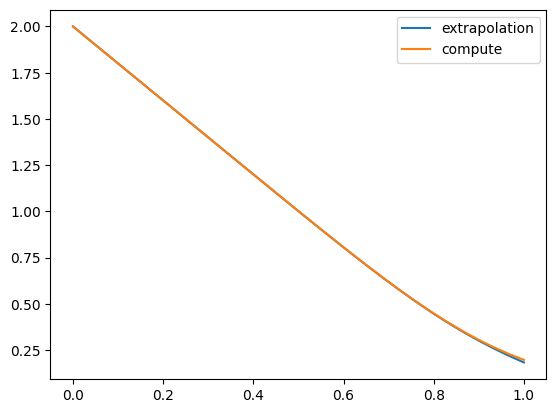

In [ ]:
plt.plot(np.linspace(0.,1,30),gap_true,label="extrapolation")
plt.plot(np.linspace(0.,1,30),gap_compute,label="compute")

plt.legend()

In [ ]:
np.save("q9_extr",gap_true)
np.save("q9_compute",gap_compute)

We have obtained in the same way the results for $L=5,7$. All this data is in the files "qL_extr.npy", "qL_compute.npy", which are in our submission files. This data can be used to estimate the transition point.